# FYP Financial Application

## Import Libraries and Connect to Google Drive

In [0]:
"""
Author: Yao Lei Xu

References:
    
    [1] Yang, Y., Krompass, D. and Tresp, V., 2017 
    "Tensor-train recurrent neural networks for video classification" 
    arXiv preprint arXiv:1707.01786

    [2] Novikov, Alexander and Podoprikhin, Dmitry and Osokin, Anton and Vetrov, Dmitry
    "Tensorizing Neural Networks"
    Proceedings of Advances in Neural Information Processing Systems 28 (NIPS) 2015

"""

%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
# Import Libraries
import numpy as np
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from seaborn import heatmap

# Import Deep Learning Tools
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import initializers
from keras.layers import Dense, SimpleRNN, LSTM, Flatten
from keras.layers.recurrent import Recurrent
from keras.models import Sequential
from keras.optimizers import sgd
from keras.optimizers import Adam, sgd
from keras.utils.np_utils import to_categorical
from tensorflow import set_random_seed as tf_random_seed

# Import Colab Tools
from google.colab import drive 

# Set seeds
np.random.seed(100)
tf_random_seed(100)

Using TensorFlow backend.


In [0]:
# Access files in the drive
drive.mount('/content/gdrive')

## Define TT Layers

The following code builds on the implementation in [1] by Yang et al. by changing and formatting the code to be compattible with the current version of Keras. The algorithm for forward computation of the Tensor-Train weight matrix is originally developed by [2] Novikov et al. 

### TT Fully Connected Layer

In [0]:
class TTFCL (Layer):
    
    # define initial variables needed for implementation
    def __init__(self, tt_ips, tt_ops, tt_ranks, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='zeros', **kwargs):

        # Tensor Train Variables. 
        self.tt_ips = np.array(tt_ips)
        self.tt_ops = np.array(tt_ops)
        self.tt_ranks = np.array(tt_ranks)
        self.num_dim = np.array(tt_ips).shape[0]
        self.param_n = np.sum(self.tt_ips*self.tt_ops*self.tt_ranks[1:]*self.tt_ranks[:-1])
  
        # Neural Networks Variables
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        super(TTFCL, self).__init__(**kwargs)

    # define weights for each core
    def build(self, input_shape):

        # Initalize weights for the TT FCL. Note that Keras will pass the optimizer directly on these core parameters
        self.kernel = self.add_weight((self.param_n, ),initializer=self.kernel_initializer,name='kernel')
        self.bias = self.add_weight((np.prod(self.tt_ops), ),initializer=self.bias_initializer,name='bias')

        # Below is the code from [2], [1] that pre-calculate the indices, shapes and cores. 
        self.inds = np.zeros(self.num_dim).astype('int32')
        self.shapes = np.zeros((self.num_dim, 2)).astype('int32')
        self.cores = [None] * self.num_dim

        # iterate through all TT-Cores and set up the shapes of each core
        for k in range(self.num_dim - 1, -1, -1):
            # This is the shape of (m_k * r_{k+1}) * (r_k * n_k)
            self.shapes[k] = (self.tt_ips[k]*self.tt_ranks[k + 1], self.tt_ranks[k]*self.tt_ops[k])
            # Note that self.cores store only the pointers to the parameter vector
            self.cores[k] = self.kernel[self.inds[k]:(self.inds[k] + np.prod(self.shapes[k]))]
            if k>0:
                self.inds[k - 1] = self.inds[k] + np.prod(self.shapes[k])

        # Print for debugging
        print ('Input data shape: ', input_shape)
        print ('Input tensor shape: ' + str(self.tt_ips))
        print ('Output tensor shape: ' + str(self.tt_ops))
        print ('TT ranks: ' + str(self.tt_ranks))
        print ('Core shapes: \n', self.shapes)
        
        print ('TT total parameters n: ', self.param_n)
        print ('Equivalent FCL parameters n: ', (np.prod(self.tt_ips) * np.prod(self.tt_ops)))
        

    # Implementing the layer logic: serial dot product with TT-cores and pass through the neuron activation function
    def call(self, x, mask=None):

        res = x
        
        # iterate through all cores and perform dot product [2], [1]
        for k in range(self.num_dim - 1, -1, -1):
            
            # reshaping the matrix products to match the sizes of each core: (-1, m_k*r_{k+1}), (m_k*r_{k+1}, r_k*n_k)
            res = K.dot(K.reshape(res, (-1, self.shapes[k][0])), K.reshape(self.cores[k], self.shapes[k]))
            res = K.transpose(K.reshape(res, (-1, self.tt_ops[k])))

        res = K.transpose(K.reshape(res, (-1, K.shape(x)[0])))

        res = K.bias_add(res, self.bias)

        if self.activation is not None: res = self.activation(res)

        return res

    # Compute input/output shapes
    def compute_output_shape(self, input_shape):
        
        return (input_shape[0], np.prod(self.tt_ops))


### TT Recurrent Layer

In [0]:
class TTRL(Recurrent):

    # define initial variables needed for implementation
    def __init__(self, tt_ips, tt_ops, tt_ranks, activation='tanh', kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', **kwargs):

        # TT Variables
        self.tt_ips = np.array(tt_ips)
        self.tt_ops = np.array(tt_ops)
        self.tt_ranks = np.array(tt_ranks)
        self.num_dim = self.tt_ips.shape[0]
        self.param_n = np.sum(self.tt_ips*self.tt_ops*self.tt_ranks[1:]*self.tt_ranks[:-1])
        
        # Neural Net Variables
        self.units = np.prod(np.array(tt_ops))
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        super(TTRL, self).__init__(**kwargs)

    # define weights for each core
    def build(self, input_shape):
        
        # Initialize states needed for recurrent calculations
        self.states = [None]
        if self.stateful:
            self.reset_states()

        # Initalize weights for the TT FCL. Note that Keras will pass the optimizer directly on these core parameters
        self.kernel = self.add_weight((self.param_n,), initializer=self.kernel_initializer, name='kernel')
        self.bias = self.add_weight((np.prod(self.tt_ops), ), initializer=self.bias_initializer, name='bias')

        # Below is the code from [2], [1] that pre-calculate the indices, shapes and cores. 
        self.inds = np.zeros(self.num_dim).astype('int32')
        self.shapes = np.zeros((self.num_dim, 2)).astype('int32')
        self.cores = [None] * self.num_dim

        # iterate through all TT-Cores and set up the shapes of each core        
        for k in range(self.num_dim - 1, -1, -1):
            self.shapes[k] = (self.tt_ips[k] * self.tt_ranks[k + 1], self.tt_ranks[k] * self.tt_ops[k])
            self.cores[k] = self.kernel[self.inds[k]:self.inds[k] + np.prod(self.shapes[k])]
            if 0 < k:
                self.inds[k - 1] = self.inds[k] + np.prod(self.shapes[k])

        # setup the recurrent weight matrix
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),name='recurrent_kernel',initializer=self.recurrent_initializer)
                                
        # Print for debugging
        print ('Input data shape: ', input_shape)
        print ('Input tensor shape: ' + str(self.tt_ips))
        print ('Output tensor shape: ' + str(self.tt_ops))
        print ('TT ranks: ' + str(self.tt_ranks))
        print ('Core shapes: \n', self.shapes)                                
        
        print ('TT total parameters n: ', self.param_n)
        print ('Equivalent FCL parameters n: ', (np.prod(self.tt_ips) * np.prod(self.tt_ops)))
        
    def preprocess_input(self, x, training=None):
        return x

    def step(self, x, states):

        # Compute the feature map, iterate through all cores and perform dot product [2], [1]
        res = x
        for k in range(self.num_dim - 1, -1, -1):
            res = K.dot(K.reshape(res, (-1, self.shapes[k][0])), K.reshape(self.cores[k], self.shapes[k]))
            res = K.transpose(K.reshape(res, (-1, self.tt_ops[k])))
        res = K.transpose(K.reshape(res, (-1, K.shape(x)[0])))
                
        h = res + self.bias

        # Compute the recurrent map
        prev_output = states[0]
        output = h + K.dot(prev_output, self.recurrent_kernel)
        output = self.activation(output)

        return output, [output]

## Define Models

In [0]:
# Define model architecture: Fully Connected Model
def create_FCMdl(n=100000, lr=1e-5):
    
    model = Sequential()
    model.add(Dense(units=n, activation='sigmoid'))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(optimizer=sgd(lr), loss='categorical_crossentropy', metrics=['acc'])

    return model  

In [0]:
# Define model architecture: TT Fully Connected Model
def create_TTFCMdl(tt_ips, tt_ops, tt_ranks, lr=1e-5):
    
    model = Sequential()
    model.add(TTFCL(tt_ips=tt_ips, tt_ops=tt_ops, tt_ranks=tt_ranks, activation='sigmoid'))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(optimizer=sgd(lr), loss='categorical_crossentropy', metrics=['acc'])

    return model  

In [0]:
# Define model architecture: Recurrent Model
# Note n is much smaller in this case because of memory constraints
def create_RNNMdl(n=4**5, lr=1e-3):
    
    model = Sequential()
    model.add(SimpleRNN(units=n, activation='tanh', return_sequences=False))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(optimizer=sgd(lr), loss='categorical_crossentropy', metrics=['acc'])

    return model  

In [0]:
# Define model architecture: TT Recurrent Model
def create_TTRNNMdl(tt_ips, tt_ops, tt_ranks, lr=1e-3):
    
    model = Sequential()
    model.add(TTRL(tt_ips, tt_ops, tt_ranks, activation='tanh', return_sequences=False)) # activation sigmoid to introduce gating instead
    model.add(Dense(units=3, activation='softmax'))
    model.compile(optimizer=sgd(lr), loss='categorical_crossentropy', metrics=['acc'])

    return model  

## Define Utilifty Functions

In [0]:
# Calculate the magnitude and duration of the maximum draw-down
def MDD (my_rs):
  
  xs = my_rs.cumsum().values
  i = np.argmax(np.maximum.accumulate(xs) - xs) 
  j = np.argmax(xs[:i])

  return (xs[i]-xs[j]), (i-j)

# Compute the performance of the portfolio
def PortfolioPerformance (my_rs):
  
  df = pd.Series()
  df['Total Return (%)'] = sum(my_rs)
  df['Winning Trades (%)'] = len(my_rs[my_rs>0])/len(my_rs)
  df['Average Return (%)'] = my_rs.mean()
  df['Average Positive Returns (%)'] = my_rs[my_rs>0].mean()
  df['Average Negative Returns (%)'] = my_rs[my_rs<0].mean()
  df['Max Drawdown (%)'] = MDD(my_rs)[0]
  df['Drawdown Duration (Days)'] = MDD(my_rs)[1]
  df['Sharpe Ratio'] = my_rs.mean()/my_rs.std()
  df['Skew'] = my_rs.skew()
  df['Kurtosis'] = my_rs.kurtosis()
  
  return df

In [0]:
# Custom function to retrieve the local feature data
def get_features (symbol = 'EQ/SPX', path_ip = 'gdrive/My Drive/Financial Data/Features4/'):
    
    file_ip = path_ip+symbol+'.csv'
    data = pd.read_csv(file_ip, header=0, index_col=0)
    data.index = pd.to_datetime(data.index)
    data = data.astype(float)
    data = data.sort_index()
    
    return data

In [0]:
# All available symbols
symbols = ['EQ/SPX','EQ/MXCA','EQ/UKX','EQ/FTSEMIB','EQ/SHSZ300','EQ/NKY',
          'FX/CHFUSD','FX/CADUSD','FX/GBPUSD','FX/EURUSD','FX/CNYUSD','FX/JPYUSD',
          'CO/GC1','CO/HG1','CO/CL1','CO/NG1','CO/S1','CO/C1',
          'FI/USGG10YR','FI/GCAN10YR','FI/GUKG10','FI/GBTPGR10','FI/GCNY10YR','FI/GJGB10']

In [0]:
get_features(symbols[0]).shape

(3284, 20)

## Standard Neural Network Model

### Data Pre-Processing

In [0]:
# Define Output
labels = pd.read_csv('gdrive/My Drive/Financial Data/Features4/labels4.csv', index_col=0, header=0)
y = np.sign(labels['JPYUSD'])+1 # 0,1,2: negative, neural, positive returns
y = to_categorical(y) # one hot encoding

In [0]:
# Set up the input tensor
s0 = 3284   # mode 0 = samples (= time steps for fully connected models)
s1 = 20*6*4 # mode 1 = features (20 features) * assets (6 per asset class) * asset classes (0=EQ, 1=FX, 2=CO, 3=FI) 

X = np.zeros((s0,s1))

# get the values
for symbol in symbols:
  
  tmp_idx1 = symbols.index(symbol)*20
  tmp_idx2 = tmp_idx1+20
  
  X[:, tmp_idx1:tmp_idx2] = get_features(symbol).values

In [0]:
# Split the training and testing data
tr_pct = 0.90 # 90% split
split_idx = int(s0*tr_pct)

X_tr = X[:split_idx]
X_te = X[split_idx:]

y_tr = y[:split_idx]
y_te = y[split_idx:]

print('X_tr, X_te shapes: ', X_tr.shape, X_te.shape)
print('y_tr, y_te shapes: ', y_tr.shape, y_te.shape)

X_tr, X_te shapes:  (2955, 480) (329, 480)
y_tr, y_te shapes:  (2955, 3) (329, 3)


In [0]:
# Scale data before the neural network 
scaler = preprocessing.StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

### Model Training

In [0]:
train_loss, valid_loss = [], [] # Initialize lists for later analysis
train_acc, valid_acc = [], [] # Initialize lists for later analysis

weights_FCL1, weights_FCL2 = [], [] # store FCL weights

# Train the model
n_epochs = 20
batch_size = 22*3
model = create_FCMdl()

start = datetime.now()
for e in range(n_epochs):
    
    print('epoch: ', e)
    history = model.fit(x=X_tr, y=y_tr, verbose=1, epochs=1, batch_size=batch_size, validation_split=0.1)
    train_loss.append(history.history['loss'][0])
    valid_loss.append(history.history['val_loss'][0])
    train_acc.append(history.history['acc'][0]*100)
    valid_acc.append(history.history['val_acc'][0]*100)
    
    weights = model.get_weights()
    weights_FCL1.append(weights[0])
    weights_FCL2.append(weights[2])

print('Time elapsed: ', datetime.now()-start)

Instructions for updating:
Colocations handled automatically by placer.
epoch:  0
Instructions for updating:
Use tf.cast instead.
Train on 2659 samples, validate on 296 samples
Epoch 1/1
2659/2659 [==============================] - 29s 11ms/step - loss: 0.9350 - acc: 0.4645 - val_loss: 0.7801 - val_acc: 0.5000
epoch:  1
Train on 2659 samples, validate on 296 samples
Epoch 1/1
2659/2659 [==============================] - 26s 10ms/step - loss: 0.7695 - acc: 0.4979 - val_loss: 0.7500 - val_acc: 0.5101
epoch:  2
Train on 2659 samples, validate on 296 samples
Epoch 1/1
2659/2659 [==============================] - 26s 10ms/step - loss: 0.7534 - acc: 0.4904 - val_loss: 0.7387 - val_acc: 0.5270
epoch:  3
Train on 2659 samples, validate on 296 samples
Epoch 1/1
2659/2659 [==============================] - 25s 10ms/step - loss: 0.7482 - acc: 0.4998 - val_loss: 0.7397 - val_acc: 0.4493
epoch:  4
Train on 2659 samples, validate on 296 samples
Epoch 1/1
2659/2659 [==============================] - 

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100000)            48100000  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 300003    
Total params: 48,400,003
Trainable params: 48,400,003
Non-trainable params: 0
_________________________________________________________________


### Analysis

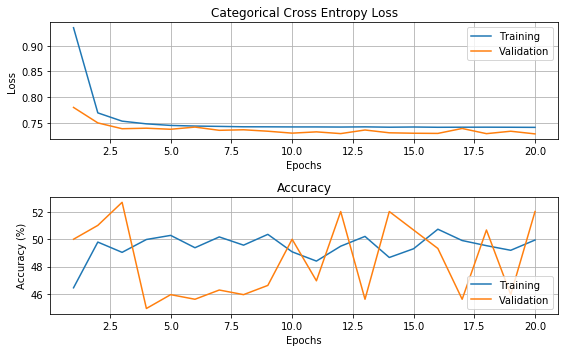

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,1) # plot 3 by 2

axs[0].plot([i for i in range(1,n_epochs+1)], train_loss)
axs[0].plot([i for i in range(1,n_epochs+1)], valid_loss)
axs[0].legend(['Training', 'Validation'])
axs[0].set_title('Categorical Cross Entropy Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid()

axs[1].plot([i for i in range(1,n_epochs+1)], train_acc)
axs[1].plot([i for i in range(1,n_epochs+1)], valid_acc)
axs[1].legend(['Training', 'Validation'])
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid()

fig.set_size_inches(8,5)
fig.tight_layout()

In [0]:
dw_FCL1 = []
dw_FCL2 = []
for i in range(1,len(weights_FCL1)):
  dw_FCL1.append(np.mean(abs((weights_FCL1[i]-weights_FCL1[i-1]).reshape(-1))))
  dw_FCL2.append(np.mean(abs((weights_FCL2[i]-weights_FCL2[i-1]).reshape(-1))))
  
pdw_FCL1 = []
pdw_FCL2 = []
for i in range(1,len(weights_FCL1)):
  pdw_FCL1.append(100*np.mean(abs(((weights_FCL1[i]-weights_FCL1[i-1])/weights_FCL1[i-1]).reshape(-1))))
  pdw_FCL2.append(100*np.mean(abs(((weights_FCL2[i]-weights_FCL2[i-1])/weights_FCL2[i-1]).reshape(-1))))

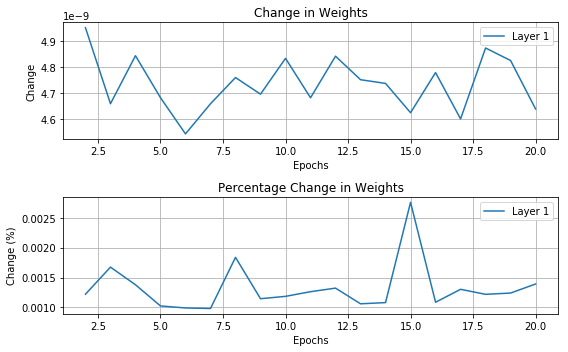

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,1) # plot 3 by 2

axs[0].plot([i for i in range(2,n_epochs+1)], dw_FCL1)
# axs[0].plot([i for i in range(2,n_epochs+1)], dw_FCL2)
axs[0].legend(['Layer 1', 'Layer 2'])
axs[0].set_title('Change in Weights')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Change')
axs[0].grid()

axs[1].plot([i for i in range(2,n_epochs+1)], pdw_FCL1)
# axs[1].plot([i for i in range(2,n_epochs+1)], pdw_FCL2)
axs[1].legend(['Layer 1', 'Layer 2'])
axs[1].set_title('Percentage Change in Weights')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Change (%)')
axs[1].grid()

fig.set_size_inches(8,5)
fig.tight_layout()

### Backtest

Total Return, Sharpe:  1.6022989024605716 0.025584821094535852


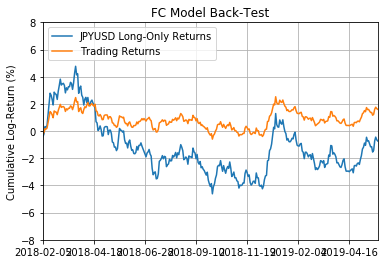

In [0]:
returns = labels['JPYUSD'][-y_te.shape[0]:]*100
positions = model.predict(X_te).argmax(1)-1
positions = positions*model.predict(X_te).max(1)
NN_rs = returns*positions

returns.cumsum().plot()
NN_rs.cumsum().plot()
plt.grid()
plt.ylim([-8,8])
plt.legend(['JPYUSD Long-Only Returns', 'Trading Returns'], loc='upper left')
plt.title('FC Model Back-Test')
plt.ylabel('Cumulative Log-Return (%)')

print('Total Return, Sharpe: ', NN_rs.cumsum()[-1], NN_rs.mean()/NN_rs.std())

In [0]:
PortfolioPerformance (NN_rs)

Total Return (%)                  1.602299
Winning Trades (%)                0.501520
Average Return (%)                0.004870
Average Positive Returns (%)      0.150539
Average Negative Returns (%)     -0.144327
Max Drawdown (%)                 -3.058614
Drawdown Duration (Days)        134.000000
Sharpe Ratio                      0.025585
Skew                              0.061947
Kurtosis                          0.630156
dtype: float64

## TT Neural Network Model

### Data Pre-Processing

In [0]:
# Define Output
labels = pd.read_csv('gdrive/My Drive/Financial Data/Features4/labels4.csv', index_col=0, header=0)
y = np.sign(labels['JPYUSD'])+1 # 0,1,2: negative, neural, positive returns
y = to_categorical(y) # one hot encoding

In [0]:
# Set up the input tensor
s0 = 3284 # mode 0 = samples (= time steps for fully connected models)
s1 = 20  # mode 1 = features (20 features)
s2 = 6   # mode 2 = assets (6 per asset class)
s3 = 4   # mode 3 = asset classes (0=EQ, 1=FX, 2=CO, 3=FI) 

X = np.zeros((s0,s1,s2,s3))

# get the values
for symbol in symbols:
  
  idxC = int(symbols.index(symbol)/6) # asset index
  idxA = symbols.index(symbol)%6 # asset class index
  
  X[:,:,idxA,idxC] = get_features(symbol).values # add values
  #print(symbol, idxC, idxA)
  #print(X[:,:,idxA,idxC])


In [0]:
# Split the training and testing data
tr_pct = 0.90 # 90% split
split_idx = int(s0*tr_pct)

X_tr = X[:split_idx]
X_te = X[split_idx:]

y_tr = y[:split_idx]
y_te = y[split_idx:]

print('X_tr, X_te shapes: ', X_tr.shape, X_te.shape)
print('y_tr, y_te shapes: ', y_tr.shape, y_te.shape)

X_tr, X_te shapes:  (2955, 20, 6, 4) (329, 20, 6, 4)
y_tr, y_te shapes:  (2955, 3) (329, 3)


In [0]:
# Scale data before the neural network 
scaler = preprocessing.StandardScaler()
for symbol in symbols:
  
  idxC = int(symbols.index(symbol)/6) # asset index
  idxA = symbols.index(symbol)%6 # asset class index

  tmpX = X_tr[:,:,idxA,idxC]   
  scaler.fit(tmpX)
  X_tr[:,:,idxA,idxC] = scaler.transform(tmpX)
  
  tmpX = X_te[:,:,idxA,idxC]   
  X_te[:,:,idxA,idxC] = scaler.transform(tmpX)


In [0]:
X_tr = X_tr.reshape(-1, 2, 2, 5, 6, 4)
X_te = X_te.reshape(-1, 2, 2, 5, 6, 4)

### Model Training

In [0]:
n_epochs = 20
batch_size = 22*3
rs = [1,2,3,4,5,6,7,8,9,10]
elapsed_ts = []
n_params = []

tt_ips = [2,2,5,6,4]
tt_ops = [10,10,10,10,10]

tr_losses = pd.Series()
te_losses = pd.Series()
all_portfolioperformance = pd.DataFrame()
best_result = 0

In [0]:
for r in rs:
  
  print('\n', r)

  tt_ranks = [1,r,r,r,r,1]
  model = create_TTFCMdl(tt_ips,tt_ops,tt_ranks)

  train_loss, valid_loss = [], [] # Initialize lists for later analysis
  train_acc, valid_acc = [], [] # Initialize lists for later analysis
  weights_FCL1, weights_FCL2 = [], [] # store FCL weights

  # Train the Model
  start = datetime.now()
  for e in range(n_epochs):

      print('epoch: ', e)
      history = model.fit(x=X_tr, y=y_tr, verbose=1, epochs=1, batch_size=batch_size, validation_split=0.1)
      train_loss.append(history.history['loss'][0])
      valid_loss.append(history.history['val_loss'][0])
      train_acc.append(history.history['acc'][0]*100)
      valid_acc.append(history.history['val_acc'][0]*100)
    
      weights = model.get_weights()
      weights_FCL1.append(weights[0])
      weights_FCL2.append(weights[2])

  # Compute Complexity Data
  elapsed_ts.append((datetime.now()-start).microseconds)
  n_params.append(np.sum(np.array(tt_ips)*np.array(tt_ops)*np.array(tt_ranks)[1:]*np.array(tt_ranks)[:-1]))

  # Compute Neural Network Performance Data
  if not r in all_portfolioperformance.columns:
    tr_losses[str(r)] = model.evaluate(X_tr, y_tr, verbose=0)[0]
    te_losses[str(r)] = model.evaluate(X_te, y_te, verbose=0)[0]
  
  # Compute Portfolio Performance Data
  returns = labels['JPYUSD'][-y_te.shape[0]:]*100
  positions = model.predict(X_te).argmax(1)-1
  positions = positions*model.predict(X_te).max(1)
  NN_rs = returns*positions
  if not r in all_portfolioperformance.columns:
    all_portfolioperformance[r] = PortfolioPerformance (NN_rs)
    print(all_portfolioperformance)
  
  # Store best performing model
  if all_portfolioperformance[r]['Winning Trades (%)'] > 0.5: # win rate > 1/2
    if all_portfolioperformance[r]['Total Return (%)'] > best_result: # select maximum total return
      best_result = all_portfolioperformance[r]['Total Return (%)']
      best_model = model
      best_train_loss = train_loss
      best_valid_loss = valid_loss
      best_train_acc = train_acc
      best_valid_acc = valid_acc
      best_weights_FCL1 = weights_FCL1
      best_weights_FCL2 = weights_FCL2
      
      print(best_result)


 1
epoch:  0
Input data shape:  (None, 2, 2, 5, 6, 4)
Input tensor shape: [2 2 5 6 4]
Output tensor shape: [10 10 10 10 10]
TT ranks: [1 1 1 1 1 1]
Core shapes: 
 [[ 2 10]
 [ 2 10]
 [ 5 10]
 [ 6 10]
 [ 4 10]]
TT total parameters n:  190
Equivalent FCL parameters n:  48000000
Train on 2659 samples, validate on 296 samples
Epoch 1/1
2659/2659 [==============================] - 7s 3ms/step - loss: 0.8799 - acc: 0.4957 - val_loss: 0.7790 - val_acc: 0.4561
epoch:  1
Train on 2659 samples, validate on 296 samples
Epoch 1/1
2659/2659 [==============================] - 7s 3ms/step - loss: 0.7668 - acc: 0.5047 - val_loss: 0.7462 - val_acc: 0.5372
epoch:  2
Train on 2659 samples, validate on 296 samples
Epoch 1/1
2659/2659 [==============================] - 7s 3ms/step - loss: 0.7533 - acc: 0.5006 - val_loss: 0.7414 - val_acc: 0.4561
epoch:  3
Train on 2659 samples, validate on 296 samples
Epoch 1/1
2659/2659 [==============================] - 7s 3ms/step - loss: 0.7479 - acc: 0.4836 - val_loss

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ttfcl_10 (TTFCL)             (None, 100000)            113600    
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 300003    
Total params: 413,603
Trainable params: 413,603
Non-trainable params: 0
_________________________________________________________________


### Performance Table

In [0]:
all_portfolioperformance

,1,2,3,4,5,6,7,8,9,10
Total Return (%),-0.998512,0.389235,0.353684,1.584443,0.245985,-1.137820,-0.356739,-2.973803,-0.361863,-3.531295
Winning Trades (%),0.489362,0.501520,0.501520,0.510638,0.507599,0.489362,0.489362,0.468085,0.489362,0.483283
Average Return (%),-0.003035,0.001183,0.001075,0.004816,0.000748,-0.003458,-0.001084,-0.009039,-0.001100,-0.010733
Average Positive Returns (%),0.144363,0.145580,0.145355,0.144988,0.139259,0.140351,0.146725,0.140508,0.144383,0.133628
Average Negative Returns (%),-0.146915,-0.146779,-0.146769,-0.144136,-0.144719,-0.143845,-0.145330,-0.143093,-0.143076,-0.148372
Max Drawdown (%),-4.752956,-3.019823,-3.043754,-2.984434,-2.597457,-5.840160,-4.810632,-6.537370,-4.726949,-8.852064
Drawdown Duration (Days),272.000000,62.000000,62.000000,62.000000,32.000000,183.000000,134.000000,272.000000,134.000000,149.000000
Sharpe Ratio,-0.016169,0.006273,0.005702,0.025823,0.004081,-0.018843,-0.005754,-0.049433,-0.005930,-0.058983
Skew,0.084046,-0.078230,-0.090314,-0.054830,0.025724,0.022090,0.085359,-0.097439,0.082939,-0.096525
Kurtosis,0.607700,0.620504,0.634872,0.631778,0.633802,0.664500,0.623357,0.612376,0.631203,0.618324


### Complexity Analysis

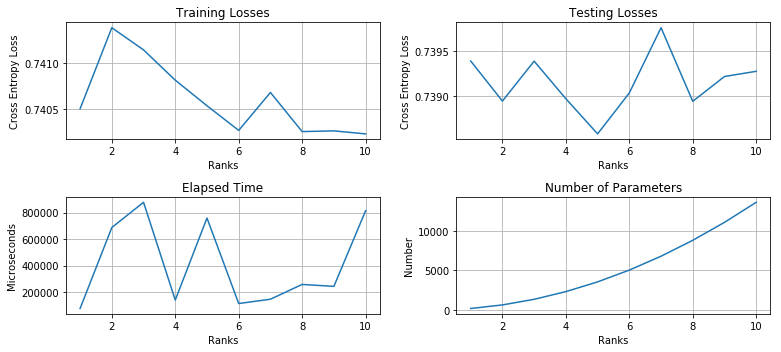

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,2) # plot 3 by 2

axs[0][0].plot(rs, tr_losses)
axs[0][0].set_title('Training Losses')
axs[0][0].set_xlabel('Ranks')
axs[0][0].set_ylabel('Cross Entropy Loss')
axs[0][0].grid()

axs[0][1].plot(rs, te_losses)
axs[0][1].set_title('Testing Losses')
axs[0][1].set_xlabel('Ranks')
axs[0][1].set_ylabel('Cross Entropy Loss')
axs[0][1].grid()

axs[1][0].plot(rs, elapsed_ts)
axs[1][0].set_title('Elapsed Time')
axs[1][0].set_xlabel('Ranks')
axs[1][0].set_ylabel('Microseconds')
axs[1][0].grid()

axs[1][1].plot(rs, n_params)
axs[1][1].set_title('Number of Parameters')
axs[1][1].set_xlabel('Ranks')
axs[1][1].set_ylabel('Number')
axs[1][1].grid()

fig.set_size_inches(11,5)
fig.tight_layout()

### Training Curves

In [0]:
model = best_model
train_loss = best_train_loss
valid_loss = best_valid_loss
trani_acc = best_train_acc
valid_acc = best_valid_acc
weights_FCL1 = best_weights_FCL1
weights_FCL2 = best_weights_FCL2

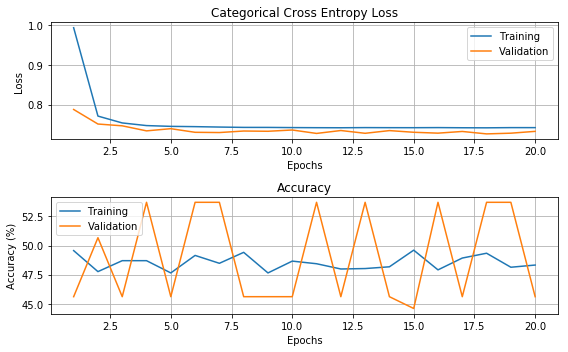

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,1) # plot 3 by 2

axs[0].plot([i for i in range(1,n_epochs+1)], train_loss)
axs[0].plot([i for i in range(1,n_epochs+1)], valid_loss)
axs[0].legend(['Training', 'Validation'])
axs[0].set_title('Categorical Cross Entropy Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid()

axs[1].plot([i for i in range(1,n_epochs+1)], train_acc)
axs[1].plot([i for i in range(1,n_epochs+1)], valid_acc)
axs[1].legend(['Training', 'Validation'])
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid()

fig.set_size_inches(8,5)
fig.tight_layout()

In [0]:
wcore_1 = [] 
wcore_2 = []
wcore_3 = []
wcore_4 = []
wcore_5 = []

print(weights_FCL1[0][model.layers[0].inds[4]:model.layers[0].inds[3]].shape)
print(weights_FCL1[0][model.layers[0].inds[3]:model.layers[0].inds[2]].shape)
print(weights_FCL1[0][model.layers[0].inds[2]:model.layers[0].inds[1]].shape)
print(weights_FCL1[0][model.layers[0].inds[1]:model.layers[0].inds[0]].shape)
print(weights_FCL1[0][model.layers[0].inds[0]:].shape)

for i in range(len(weights_FCL1)): # iterate over epochs

  wcore_5.append(weights_FCL1[i][model.layers[0].inds[4]:model.layers[0].inds[3]])
  wcore_4.append(weights_FCL1[i][model.layers[0].inds[3]:model.layers[0].inds[2]])
  wcore_3.append(weights_FCL1[i][model.layers[0].inds[2]:model.layers[0].inds[1]])
  wcore_2.append(weights_FCL1[i][model.layers[0].inds[1]:model.layers[0].inds[0]])
  wcore_1.append(weights_FCL1[i][model.layers[0].inds[0]:])

(160,)
(960,)
(800,)
(320,)
(80,)


In [0]:
dwcore_1 = []
dwcore_2 = []
dwcore_3 = []
dwcore_4 = []
dwcore_5 = []

for i in range(1,len(weights_FCL1)):
  dwcore_1.append(np.mean(abs(wcore_1[i]-wcore_1[i-1])))
  dwcore_2.append(np.mean(abs(wcore_2[i]-wcore_2[i-1])))
  dwcore_3.append(np.mean(abs(wcore_3[i]-wcore_3[i-1])))
  dwcore_4.append(np.mean(abs(wcore_4[i]-wcore_4[i-1])))
  dwcore_5.append(np.mean(abs(wcore_5[i]-wcore_5[i-1])))
  
pdwcore_1 = []
pdwcore_2 = []
pdwcore_3 = []
pdwcore_4 = []
pdwcore_5 = []

for i in range(1,len(weights_FCL1)):
  pdwcore_1.append(100*np.mean(abs((wcore_1[i]-wcore_1[i-1])/wcore_1[i-1])))
  pdwcore_2.append(100*np.mean(abs((wcore_2[i]-wcore_2[i-1])/wcore_2[i-1])))
  pdwcore_3.append(100*np.mean(abs((wcore_3[i]-wcore_3[i-1])/wcore_3[i-1])))
  pdwcore_4.append(100*np.mean(abs((wcore_4[i]-wcore_4[i-1])/wcore_4[i-1])))
  pdwcore_5.append(100*np.mean(abs((wcore_5[i]-wcore_5[i-1])/wcore_5[i-1])))

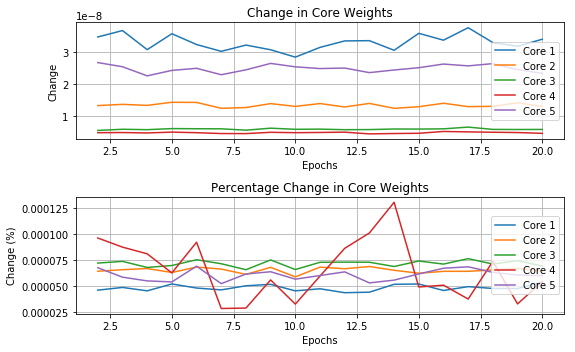

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,1) # plot 3 by 2

axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_1)
axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_2)
axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_3)
axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_4)
axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_5)
axs[0].legend(['Core 1', 'Core 2', 'Core 3', 'Core 4', 'Core 5'], loc='right')
axs[0].set_title('Change in Core Weights')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Change')
axs[0].grid()

axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_1)
axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_2)
axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_3)
axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_4)
axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_5)
axs[1].legend(['Core 1', 'Core 2', 'Core 3', 'Core 4', 'Core 5'], loc='right')
axs[1].set_title('Percentage Change in Core Weights')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Change (%)')
axs[1].grid()

fig.set_size_inches(8,5)
fig.tight_layout()

### Backtest

Total Return, Sharpe:  -4.645162834248758 -0.0046440699093613785


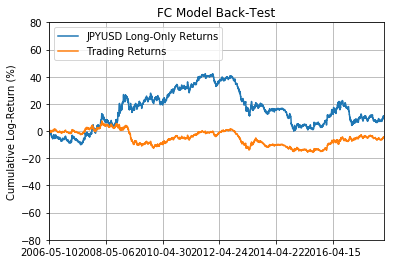

In [0]:
returns = labels['JPYUSD'][:y_tr.shape[0]]*100
positions = model.predict(X_tr).argmax(1)-1
positions = positions*model.predict(X_tr).max(1)
NN_rs = returns*positions

returns.cumsum().plot()
NN_rs.cumsum().plot()
plt.grid()
plt.ylim([-80,80])
plt.legend(['JPYUSD Long-Only Returns', 'Trading Returns'], loc='upper left')
plt.title('FC Model Back-Test')
plt.ylabel('Cumulative Log-Return (%)')

print('Total Return, Sharpe: ', NN_rs.cumsum()[-1], NN_rs.mean()/NN_rs.std())

Total Return, Sharpe:  1.5844431097591438 0.025823222742804807


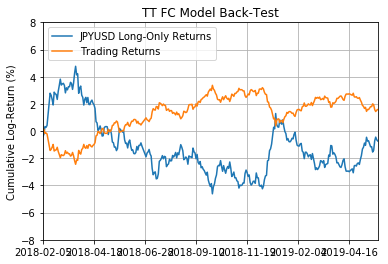

In [0]:
returns = labels['JPYUSD'][-y_te.shape[0]:]*100
positions = model.predict(X_te).argmax(1)-1
positions = positions*model.predict(X_te).max(1)
NN_rs = returns*positions

returns.cumsum().plot()
NN_rs.cumsum().plot()
plt.grid()
plt.ylim([-8,8])
plt.legend(['JPYUSD Long-Only Returns', 'Trading Returns'], loc='upper left')
plt.title('TT FC Model Back-Test')
plt.ylabel('Cumulative Log-Return (%)')

print('Total Return, Sharpe: ', NN_rs.cumsum()[-1], NN_rs.mean()/NN_rs.std())

In [0]:
PortfolioPerformance (NN_rs)

Total Return (%)                 1.584443
Winning Trades (%)               0.510638
Average Return (%)               0.004816
Average Positive Returns (%)     0.144988
Average Negative Returns (%)    -0.144136
Max Drawdown (%)                -2.984434
Drawdown Duration (Days)        62.000000
Sharpe Ratio                     0.025823
Skew                            -0.054830
Kurtosis                         0.631778
dtype: float64

## Simple Recurrent Neural Network Model

### Data Pre-Processing

In [0]:
# Define Output
labels = pd.read_csv('gdrive/My Drive/Financial Data/Features4/labels4.csv', index_col=0, header=0)
y = np.sign(labels['JPYUSD'])+1 # 0,1,2: negative, neural, positive returns
y = to_categorical(y) # one hot encoding

In [0]:
# Set up the input tensor
s0 = 3284   # mode 0 = samples (= time steps for fully connected models)
s1 = 20*6*4 # mode 1 = features (20 features) * assets (6 per asset class) * asset classes (0=EQ, 1=FX, 2=CO, 3=FI) 

X = np.zeros((s0,s1))

# get the values
for symbol in symbols:
  
  tmp_idx1 = symbols.index(symbol)*20
  tmp_idx2 = tmp_idx1+20
  
  X[:, tmp_idx1:tmp_idx2] = get_features(symbol).values

In [0]:
# Split the training and testing data
tr_pct = 0.90 # 90% split
split_idx = int(s0*tr_pct)

X_tr = X[:split_idx]
X_te = X[split_idx:]

y_tr = y[:split_idx]
y_te = y[split_idx:]

print('X_tr, X_te shapes: ', X_tr.shape, X_te.shape)
print('y_tr, y_te shapes: ', y_tr.shape, y_te.shape)

X_tr, X_te shapes:  (2955, 480) (329, 480)
y_tr, y_te shapes:  (2955, 3) (329, 3)


In [0]:
# Scale data before the neural network 
scaler = preprocessing.StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

In [0]:
# Reformat the data for recurrent models by adding time steps
time_step = 10 

RNNX_tr = np.zeros((X_tr.shape[0]-time_step,time_step,s1)) # number of samples, time step, features*assets*asset classes
RNNy_tr = np.zeros((y_tr.shape[0]-time_step,y_tr.shape[1]))

RNNX_te = np.zeros((X_te.shape[0]-time_step,time_step,s1)) # number of samples, time step, features*assets*asset classes
RNNy_te = np.zeros((y_te.shape[0]-time_step,y_te.shape[1]))

for i in range(time_step, X_tr.shape[0]):
  
  RNNX_tr[i-time_step]=X_tr[i-time_step:i]
  RNNy_tr[i-time_step]=y_tr[:i][-1]
  
for i in range(time_step, X_te.shape[0]):
  
  RNNX_te[i-time_step]=X_te[i-time_step:i]
  RNNy_te[i-time_step]=y_te[:i][-1]

### Model Training

In [0]:
train_loss, valid_loss = [], [] # Initialize lists for later analysis
train_acc, valid_acc = [], [] # Initialize lists for later analysis

weights_XH, weights_HH = [], [] # store FCL weights

# Train the model
n_epochs = 20
batch_size = 22*3
model = create_RNNMdl()

start = datetime.now()
for e in range(n_epochs):
    
    print('epoch: ', e)
    history = model.fit(x=RNNX_tr, y=RNNy_tr, verbose=1, epochs=1, batch_size=batch_size, validation_split=0.1)
    train_loss.append(history.history['loss'][0])
    valid_loss.append(history.history['val_loss'][0])
    train_acc.append(history.history['acc'][0]*100)
    valid_acc.append(history.history['val_acc'][0]*100)
    
    weights = model.get_weights()
    weights_XH.append(weights[0])
    weights_HH.append(weights[1])

print('Time elapsed: ', datetime.now()-start)

Instructions for updating:
Colocations handled automatically by placer.
epoch:  0
Instructions for updating:
Use tf.cast instead.
Train on 2650 samples, validate on 295 samples
Epoch 1/1
2650/2650 [==============================] - 8s 3ms/step - loss: 1.2713 - acc: 0.3491 - val_loss: 1.3431 - val_acc: 0.2983
epoch:  1
Train on 2650 samples, validate on 295 samples
Epoch 1/1
2650/2650 [==============================] - 7s 3ms/step - loss: 1.2069 - acc: 0.3743 - val_loss: 1.3832 - val_acc: 0.2712
epoch:  2
Train on 2650 samples, validate on 295 samples
Epoch 1/1
2650/2650 [==============================] - 7s 2ms/step - loss: 1.1592 - acc: 0.3992 - val_loss: 1.4090 - val_acc: 0.2576
epoch:  3
Train on 2650 samples, validate on 295 samples
Epoch 1/1
2650/2650 [==============================] - 7s 2ms/step - loss: 1.1179 - acc: 0.4200 - val_loss: 1.4318 - val_acc: 0.2475
epoch:  4
Train on 2650 samples, validate on 295 samples
Epoch 1/1
2650/2650 [==============================] - 6s 2ms/s

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1024)              1541120   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 1,544,195
Trainable params: 1,544,195
Non-trainable params: 0
_________________________________________________________________


In [0]:
weights[1].shape

(1024, 1024)

### Analysis

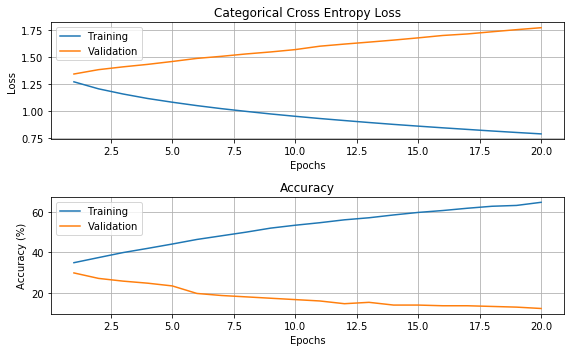

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,1) # plot 3 by 2

axs[0].plot([i for i in range(1,n_epochs+1)], train_loss)
axs[0].plot([i for i in range(1,n_epochs+1)], valid_loss)
axs[0].legend(['Training', 'Validation'])
axs[0].set_title('Categorical Cross Entropy Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid()

axs[1].plot([i for i in range(1,n_epochs+1)], train_acc)
axs[1].plot([i for i in range(1,n_epochs+1)], valid_acc)
axs[1].legend(['Training', 'Validation'])
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid()

fig.set_size_inches(8,5)
fig.tight_layout()

In [0]:
dw_XH = []
dw_HH = []
for i in range(1,len(weights_XH)):
  dw_XH.append(np.mean(abs((weights_XH[i]-weights_XH[i-1]).reshape(-1))))
  dw_HH.append(np.mean(abs((weights_HH[i]-weights_HH[i-1]).reshape(-1))))
  
pdw_XH = []
pdw_HH = []
for i in range(1,len(weights_XH)):
  pdw_XH.append(100*np.mean(abs(((weights_XH[i]-weights_XH[i-1])/weights_XH[i-1]).reshape(-1))))
  pdw_HH.append(100*np.mean(abs(((weights_HH[i]-weights_HH[i-1])/weights_HH[i-1]).reshape(-1))))

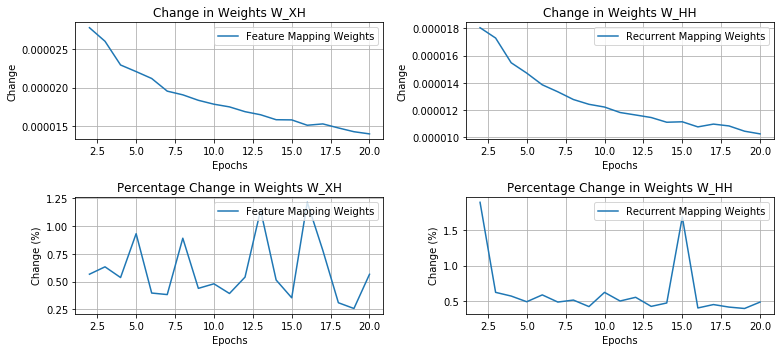

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,2) # plot 3 by 2

axs[0][0].plot([i for i in range(2,n_epochs+1)], dw_XH)
axs[0][0].set_title('Change in Weights W_XH')
axs[0][0].legend(['Feature Mapping Weights'],loc='upper right')
axs[0][0].set_xlabel('Epochs')
axs[0][0].set_ylabel('Change')
axs[0][0].grid()

axs[1][0].plot([i for i in range(2,n_epochs+1)], pdw_XH)
axs[1][0].set_title('Percentage Change in Weights W_XH')
axs[1][0].legend(['Feature Mapping Weights'],loc='upper right')
axs[1][0].set_xlabel('Epochs')
axs[1][0].set_ylabel('Change (%)')
axs[1][0].grid()

axs[0][1].plot([i for i in range(2,n_epochs+1)], dw_HH)
axs[0][1].set_title('Change in Weights W_HH')
axs[0][1].legend(['Recurrent Mapping Weights'],loc='upper right')
axs[0][1].set_xlabel('Epochs')
axs[0][1].set_ylabel('Change')
axs[0][1].grid()

axs[1][1].plot([i for i in range(2,n_epochs+1)], pdw_HH)
axs[1][1].set_title('Percentage Change in Weights W_HH')
axs[1][1].legend(['Recurrent Mapping Weights'],loc='upper right')
axs[1][1].set_xlabel('Epochs')
axs[1][1].set_ylabel('Change (%)')
axs[1][1].grid()

fig.set_size_inches(11,5)
fig.tight_layout()

### Backtest

Total Return, Sharpe:  -2.9951155883073572 -0.05865734719723076


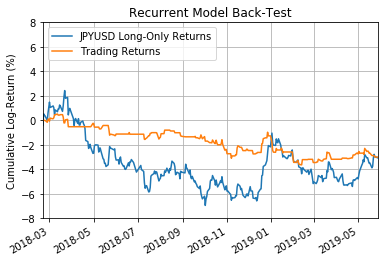

In [0]:
returns = labels['JPYUSD'][-RNNy_te.shape[0]:]*100
positions = model.predict(RNNX_te).argmax(1)-1
positions = positions*model.predict(RNNX_te).max(1)
NN_rs = returns*positions

returns.index = pd.to_datetime(returns.index)
NN_rs.index = pd.to_datetime(NN_rs.index)

returns.cumsum().plot()
NN_rs.cumsum().plot()
plt.grid()
plt.ylim([-8,8])
plt.legend(['JPYUSD Long-Only Returns', 'Trading Returns'], loc='upper left')
plt.title('Recurrent Model Back-Test')
plt.ylabel('Cumulative Log-Return (%)')

print('Total Return, Sharpe: ', NN_rs.cumsum()[-1], NN_rs.mean()/NN_rs.std())

In [0]:
PortfolioPerformance (NN_rs)

Total Return (%)                 -2.995116
Winning Trades (%)                0.213166
Average Return (%)               -0.009389
Average Positive Returns (%)      0.164507
Average Negative Returns (%)     -0.196967
Max Drawdown (%)                 -4.150816
Drawdown Duration (Days)        231.000000
Sharpe Ratio                     -0.058657
Skew                             -0.305198
Kurtosis                          4.981242
dtype: float64

## TT Recurrent Neural Network Model

### Model Training

In [0]:
n_epochs = 20
batch_size = 22*3
rs = [1,2,3,4,5,6,7,8,9,10]
elapsed_ts = []
n_params = []

tt_ips = [2,2,5,6,4]
tt_ops = [4,4,4,4,4]

tr_losses = pd.Series()
te_losses = pd.Series()
all_portfolioperformance = pd.DataFrame()
best_result = 0

In [0]:
for r in rs:
  
  print('\n', r)

  tt_ranks = [1,r,r,r,r,1]
  model = create_TTRNNMdl(tt_ips,tt_ops,tt_ranks)

  train_loss, valid_loss = [], [] # Initialize lists for later analysis
  train_acc, valid_acc = [], [] # Initialize lists for later analysis
  weights_XH, weights_HH = [], [] # store FCL weights

  # Train the Model
  start = datetime.now()
  for e in range(n_epochs):

      print('epoch: ', e)
      history = model.fit(x=RNNX_tr, y=RNNy_tr, verbose=1, epochs=1, batch_size=batch_size, validation_split=0.1)
      train_loss.append(history.history['loss'][0])
      valid_loss.append(history.history['val_loss'][0])
      train_acc.append(history.history['acc'][0]*100)
      valid_acc.append(history.history['val_acc'][0]*100)

      weights = model.get_weights()
      weights_XH.append(weights[0])
      weights_HH.append(weights[2])

  # Compute Complexity Data
  elapsed_ts.append((datetime.now()-start).microseconds)
  n_params.append(np.sum(np.array(tt_ips)*np.array(tt_ops)*np.array(tt_ranks)[1:]*np.array(tt_ranks)[:-1]))

  # Compute Neural Network Performance Data
  if not r in all_portfolioperformance.columns:
    tr_losses[str(r)] = model.evaluate(RNNX_tr, RNNy_tr, verbose=0)[0]
    te_losses[str(r)] = model.evaluate(RNNX_te, RNNy_te, verbose=0)[0]
  
  # Compute Portfolio Performance Data
  returns = labels['JPYUSD'][-RNNy_te.shape[0]:]*100
  positions = model.predict(RNNX_te).argmax(1)-1
  positions = positions*model.predict(RNNX_te).max(1)
  NN_rs = returns*positions
  if not r in all_portfolioperformance.columns:
    all_portfolioperformance[r] = PortfolioPerformance (NN_rs)
    print(all_portfolioperformance)
  
  # Store best performing model
  if all_portfolioperformance[r]['Winning Trades (%)'] > 0.5: # win rate > 1/2
    if all_portfolioperformance[r]['Total Return (%)'] > best_result: # select maximum total return
      best_result = all_portfolioperformance[r]['Total Return (%)']
      best_model = model
      best_train_loss = train_loss
      best_valid_loss = valid_loss
      best_train_acc = train_acc
      best_valid_acc = valid_acc
      best_weights_XH = weights_XH
      best_weights_HH = weights_HH
      
      print(best_result)


 1
epoch:  0
Input data shape:  (None, 10, 480)
Input tensor shape: [2 2 5 6 4]
Output tensor shape: [4 4 4 4 4]
TT ranks: [1 1 1 1 1 1]
Core shapes: 
 [[2 4]
 [2 4]
 [5 4]
 [6 4]
 [4 4]]
TT total parameters n:  76
Equivalent FCL parameters n:  491520
Train on 2650 samples, validate on 295 samples
Epoch 1/1
2650/2650 [==============================] - 7s 3ms/step - loss: 1.1241 - acc: 0.3483 - val_loss: 1.0365 - val_acc: 0.4542
epoch:  1
Train on 2650 samples, validate on 295 samples
Epoch 1/1
2650/2650 [==============================] - 6s 2ms/step - loss: 1.0598 - acc: 0.4060 - val_loss: 1.0078 - val_acc: 0.4610
epoch:  2
Train on 2650 samples, validate on 295 samples
Epoch 1/1
2650/2650 [==============================] - 6s 2ms/step - loss: 1.0066 - acc: 0.4634 - val_loss: 0.9703 - val_acc: 0.4712
epoch:  3
Train on 2650 samples, validate on 295 samples
Epoch 1/1
2650/2650 [==============================] - 6s 2ms/step - loss: 0.9584 - acc: 0.4985 - val_loss: 0.9395 - val_acc: 0.47

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ttrl_10 (TTRL)               (None, 1024)              1055040   
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 3075      
Total params: 1,058,115
Trainable params: 1,058,115
Non-trainable params: 0
_________________________________________________________________


### Performance Table

In [0]:
all_portfolioperformance

,1,2,3,4,5,6,7,8,9,10
Total Return (%),2.706154,0.371709,2.398863,0.927408,-0.161603,6.726204,3.053046,2.758548,1.383401,2.246998
Winning Trades (%),0.495298,0.482759,0.495298,0.523511,0.501567,0.529781,0.536050,0.520376,0.504702,0.501567
Average Return (%),0.008483,0.001165,0.007520,0.002907,-0.000507,0.021085,0.009571,0.008647,0.004337,0.007044
Average Positive Returns (%),0.190285,0.158394,0.172720,0.150579,0.150442,0.162846,0.156231,0.165860,0.162096,0.158920
Average Negative Returns (%),-0.173158,-0.149198,-0.157537,-0.162546,-0.155335,-0.141461,-0.163190,-0.165162,-0.159446,-0.148591
Max Drawdown (%),-3.794850,-2.075688,-3.657522,-3.439662,-4.028415,-1.756851,-2.395287,-3.126632,-4.158285,-2.278618
Drawdown Duration (Days),98.000000,87.000000,82.000000,138.000000,104.000000,28.000000,51.000000,36.000000,88.000000,66.000000
Sharpe Ratio,0.036117,0.005792,0.035533,0.014265,-0.002553,0.105584,0.046730,0.039837,0.020828,0.035072
Skew,-0.024089,0.210376,-0.148928,0.160391,0.133135,-0.114495,0.082072,-0.189876,0.250018,0.094612
Kurtosis,0.515727,1.050198,0.587937,1.150511,0.944104,1.113849,0.679665,1.218101,0.885614,1.174760


### Complexity Analysis

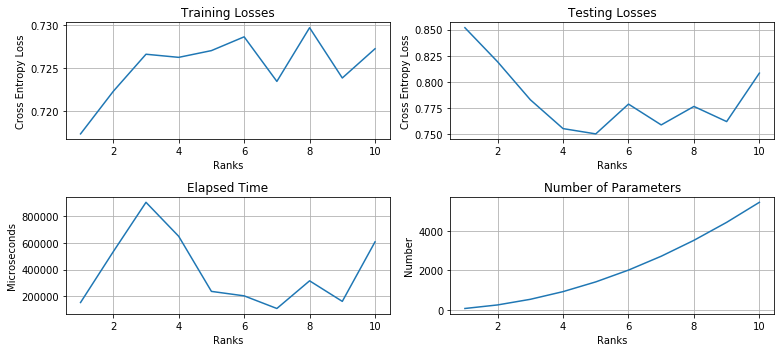

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,2) # plot 3 by 2

axs[0][0].plot(rs, tr_losses)
axs[0][0].set_title('Training Losses')
axs[0][0].set_xlabel('Ranks')
axs[0][0].set_ylabel('Cross Entropy Loss')
axs[0][0].grid()

axs[0][1].plot(rs, te_losses)
axs[0][1].set_title('Testing Losses')
axs[0][1].set_xlabel('Ranks')
axs[0][1].set_ylabel('Cross Entropy Loss')
axs[0][1].grid()

axs[1][0].plot(rs, elapsed_ts)
axs[1][0].set_title('Elapsed Time')
axs[1][0].set_xlabel('Ranks')
axs[1][0].set_ylabel('Microseconds')
axs[1][0].grid()

axs[1][1].plot(rs, n_params)
axs[1][1].set_title('Number of Parameters')
axs[1][1].set_xlabel('Ranks')
axs[1][1].set_ylabel('Number')
axs[1][1].grid()

fig.set_size_inches(11,5)
fig.tight_layout()


### Training Curves

In [0]:
model = best_model
train_loss = best_train_loss
valid_loss = best_valid_loss
trani_acc = best_train_acc
valid_acc = best_valid_acc
weights_XH = best_weights_XH
weights_HH = best_weights_HH

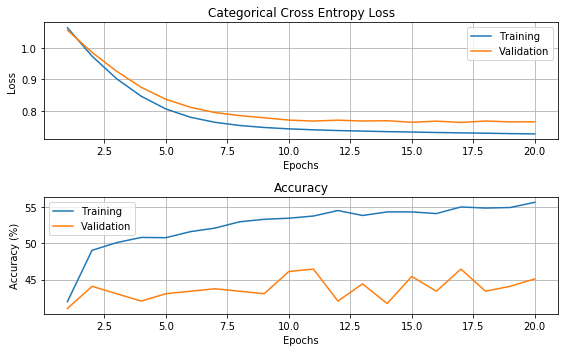

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,1) # plot 3 by 2

axs[0].plot([i for i in range(1,n_epochs+1)], train_loss)
axs[0].plot([i for i in range(1,n_epochs+1)], valid_loss)
axs[0].legend(['Training', 'Validation'])
axs[0].set_title('Categorical Cross Entropy Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid()

axs[1].plot([i for i in range(1,n_epochs+1)], train_acc)
axs[1].plot([i for i in range(1,n_epochs+1)], valid_acc)
axs[1].legend(['Training', 'Validation'])
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid()

fig.set_size_inches(8,5)
fig.tight_layout()

In [0]:
dw_XH = []
dw_HH = []
for i in range(1,len(weights_XH)):
  dw_XH.append(np.mean(abs((weights_XH[i]-weights_XH[i-1]).reshape(-1))))
  dw_HH.append(np.mean(abs((weights_HH[i]-weights_HH[i-1]).reshape(-1))))
  
pdw_XH = []
pdw_HH = []
for i in range(1,len(weights_XH)):
  pdw_XH.append(100*np.mean(abs(((weights_XH[i]-weights_XH[i-1])/weights_XH[i-1]).reshape(-1))))
  pdw_HH.append(100*np.mean(abs(((weights_HH[i]-weights_HH[i-1])/weights_HH[i-1]).reshape(-1))))

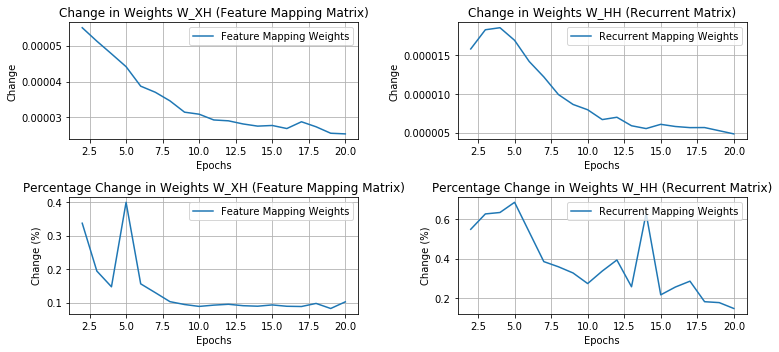

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,2) # plot 3 by 2

axs[0][0].plot([i for i in range(2,n_epochs+1)], dw_XH)
axs[0][0].set_title('Change in Weights W_XH (Feature Mapping Matrix)')
axs[0][0].legend(['Feature Mapping Weights'],loc='upper right')
axs[0][0].set_xlabel('Epochs')
axs[0][0].set_ylabel('Change')
axs[0][0].grid()

axs[1][0].plot([i for i in range(2,n_epochs+1)], pdw_XH)
axs[1][0].set_title('Percentage Change in Weights W_XH (Feature Mapping Matrix)')
axs[1][0].legend(['Feature Mapping Weights'],loc='upper right')
axs[1][0].set_xlabel('Epochs')
axs[1][0].set_ylabel('Change (%)')
axs[1][0].grid()

axs[0][1].plot([i for i in range(2,n_epochs+1)], dw_HH)
axs[0][1].set_title('Change in Weights W_HH (Recurrent Matrix)')
axs[0][1].legend(['Recurrent Mapping Weights'],loc='upper right')
axs[0][1].set_xlabel('Epochs')
axs[0][1].set_ylabel('Change')
axs[0][1].grid()

axs[1][1].plot([i for i in range(2,n_epochs+1)], pdw_HH)
axs[1][1].set_title('Percentage Change in Weights W_HH (Recurrent Matrix)')
axs[1][1].legend(['Recurrent Mapping Weights'],loc='upper right')
axs[1][1].set_xlabel('Epochs')
axs[1][1].set_ylabel('Change (%)')
axs[1][1].grid()

fig.set_size_inches(11,5)
fig.tight_layout()

In [0]:
wcore_1 = [] 
wcore_2 = []
wcore_3 = []
wcore_4 = []
wcore_5 = []

print(weights_XH[0].shape)
print(weights_HH[0].shape)
print(weights_XH[0][model.layers[0].inds[4]:model.layers[0].inds[3]].shape)
print(weights_XH[0][model.layers[0].inds[3]:model.layers[0].inds[2]].shape)
print(weights_XH[0][model.layers[0].inds[2]:model.layers[0].inds[1]].shape)
print(weights_XH[0][model.layers[0].inds[1]:model.layers[0].inds[0]].shape)
print(weights_XH[0][model.layers[0].inds[0]:].shape)

for i in range(len(weights_XH)): # iterate over epochs

  wcore_5.append(weights_XH[i][model.layers[0].inds[4]:model.layers[0].inds[3]])
  wcore_4.append(weights_XH[i][model.layers[0].inds[3]:model.layers[0].inds[2]])
  wcore_3.append(weights_XH[i][model.layers[0].inds[2]:model.layers[0].inds[1]])
  wcore_2.append(weights_XH[i][model.layers[0].inds[1]:model.layers[0].inds[0]])
  wcore_1.append(weights_XH[i][model.layers[0].inds[0]:])

(2016,)
(1024, 1024)
(96,)
(864,)
(720,)
(288,)
(48,)


In [0]:
dwcore_1 = []
dwcore_2 = []
dwcore_3 = []
dwcore_4 = []
dwcore_5 = []

for i in range(1,len(weights_XH)):
  dwcore_1.append(np.mean(abs(wcore_1[i]-wcore_1[i-1])))
  dwcore_2.append(np.mean(abs(wcore_2[i]-wcore_2[i-1])))
  dwcore_3.append(np.mean(abs(wcore_3[i]-wcore_3[i-1])))
  dwcore_4.append(np.mean(abs(wcore_4[i]-wcore_4[i-1])))
  dwcore_5.append(np.mean(abs(wcore_5[i]-wcore_5[i-1])))
  
pdwcore_1 = []
pdwcore_2 = []
pdwcore_3 = []
pdwcore_4 = []
pdwcore_5 = []

for i in range(1,len(weights_XH)):
  pdwcore_1.append(100*np.mean(abs((wcore_1[i]-wcore_1[i-1])/wcore_1[i-1])))
  pdwcore_2.append(100*np.mean(abs((wcore_2[i]-wcore_2[i-1])/wcore_2[i-1])))
  pdwcore_3.append(100*np.mean(abs((wcore_3[i]-wcore_3[i-1])/wcore_3[i-1])))
  pdwcore_4.append(100*np.mean(abs((wcore_4[i]-wcore_4[i-1])/wcore_4[i-1])))
  pdwcore_5.append(100*np.mean(abs((wcore_5[i]-wcore_5[i-1])/wcore_5[i-1])))

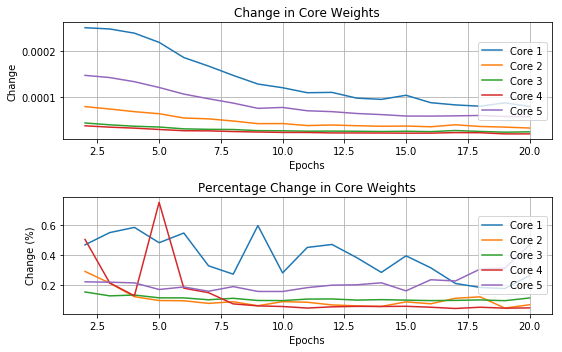

In [0]:
# Plot the training Characteristics
fig, axs = plt.subplots(2,1) # plot 3 by 2

axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_1)
axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_2)
axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_3)
axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_4)
axs[0].plot([i for i in range(2,n_epochs+1)], dwcore_5)
axs[0].legend(['Core 1', 'Core 2', 'Core 3', 'Core 4', 'Core 5'], loc='right')
axs[0].set_title('Change in Core Weights')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Change')
axs[0].grid()

axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_1)
axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_2)
axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_3)
axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_4)
axs[1].plot([i for i in range(2,n_epochs+1)], pdwcore_5)
axs[1].legend(['Core 1', 'Core 2', 'Core 3', 'Core 4', 'Core 5'], loc='right')
axs[1].set_title('Percentage Change in Core Weights')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Change (%)')
axs[1].grid()

fig.set_size_inches(8,5)
fig.tight_layout()

### Backtest

Total Return, Sharpe:  6.726203706029546 0.10558373486354335


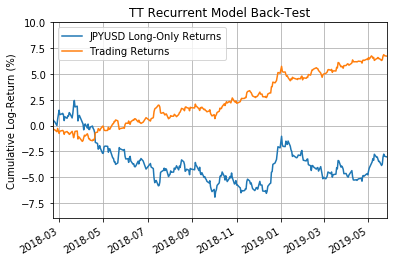

In [0]:
returns = labels['JPYUSD'][-RNNy_te.shape[0]:]*100
positions = model.predict(RNNX_te).argmax(1)-1
positions = positions*model.predict(RNNX_te).max(1)
NN_rs = returns*positions

returns.index = pd.to_datetime(returns.index)
NN_rs.index = pd.to_datetime(NN_rs.index)

returns.cumsum().plot()
NN_rs.cumsum().plot()
plt.grid()
plt.ylim([-9,10])
plt.legend(['JPYUSD Long-Only Returns', 'Trading Returns'], loc='upper left')
plt.title('TT Recurrent Model Back-Test')
plt.ylabel('Cumulative Log-Return (%)')

print('Total Return, Sharpe: ', NN_rs.cumsum()[-1], NN_rs.mean()/NN_rs.std())

In [0]:
PortfolioPerformance (NN_rs)

Total Return (%)                 6.726204
Winning Trades (%)               0.529781
Average Return (%)               0.021085
Average Positive Returns (%)     0.162846
Average Negative Returns (%)    -0.141461
Max Drawdown (%)                -1.756851
Drawdown Duration (Days)        28.000000
Sharpe Ratio                     0.105584
Skew                            -0.114495
Kurtosis                         1.113849
dtype: float64